In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import linregress, t


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
data = pd.read_csv('./new_data/reshaped.csv')

In [4]:
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())

              datetime  I_current_1_1  I_current_1_2  I_current_2_1  \
0  2024-03-08 05:45:00         0.0015         0.0015         0.0060   
1  2024-03-08 05:55:00         0.0060         0.0060         0.0240   
2  2024-03-08 06:00:00         0.0075         0.0075         0.0315   
3  2024-03-08 06:05:00         0.0195         0.0195         0.0375   
4  2024-03-08 06:10:00         0.0210         0.0210         0.0330   

   I_current_2_2  T_crimp_1  T_crimp_2  T_crimp_3  T_crimp_4  T_crimp_5  ...  \
0         0.0045      -3.14      -3.05      -3.09      -3.17      -3.13  ...   
1         0.0225      -2.91      -2.82      -2.86      -2.90      -2.86  ...   
2         0.0300      -2.71      -2.63      -2.67      -2.72      -2.70  ...   
3         0.0345      -2.60      -2.50      -2.56      -2.60      -2.58  ...   
4         0.0315      -2.42      -2.31      -2.37      -2.39      -2.40  ...   

   R_normal_3  R_normal_4  R_normal_5  R_normal_6  R_normal_8  R_normal_9  \
0         NaN  

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
indexed_data = data.set_index('datetime')
indexed_data.head(4)

,I_current_1_1,I_current_1_2,I_current_2_1,I_current_2_2,T_crimp_1,T_crimp_2,T_crimp_3,T_crimp_4,T_crimp_5,T_crimp_6,...,R_normal_3,R_normal_4,R_normal_5,R_normal_6,R_normal_8,R_normal_9,R_normal_10,G_0,RH,T_a
datetime,,,,,,,,,,,,,,,,,,,,,
2024-03-08 05:45:00,0.0015,0.0015,0.0060,0.0045,-3.14,-3.05,-3.09,-3.17,-3.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,93.400000,-2.200000
2024-03-08 05:55:00,0.0060,0.0060,0.0240,0.0225,-2.91,-2.82,-2.86,-2.90,-2.86,NaN,...,0.000500,0.000500,0.0005,0.000500,0.0005,0.000500,0.000500,0.52,93.316667,-2.036667
2024-03-08 06:00:00,0.0075,0.0075,0.0315,0.0300,-2.71,-2.63,-2.67,-2.72,-2.70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,93.153333,-2.000000
2024-03-08 06:05:00,0.0195,0.0195,0.0375,0.0345,-2.60,-2.50,-2.56,-2.60,-2.58,NaN,...,0.000462,0.000462,NaN,0.000462,NaN,0.000462,0.000462,3.84,92.893333,-2.060000


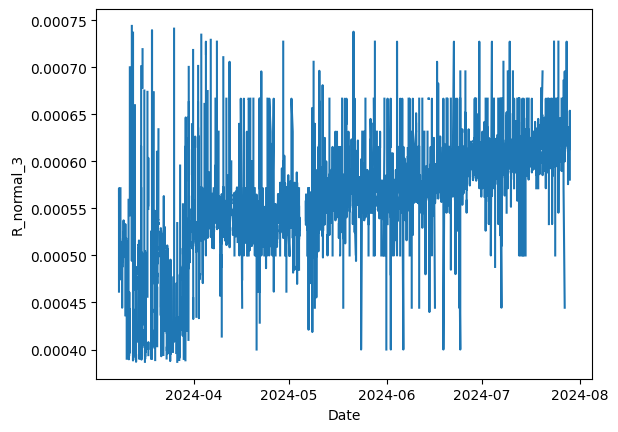

In [6]:
plt.xlabel('Date')
plt.ylabel('R_normal_3')
plt.plot(indexed_data['R_normal_3'])

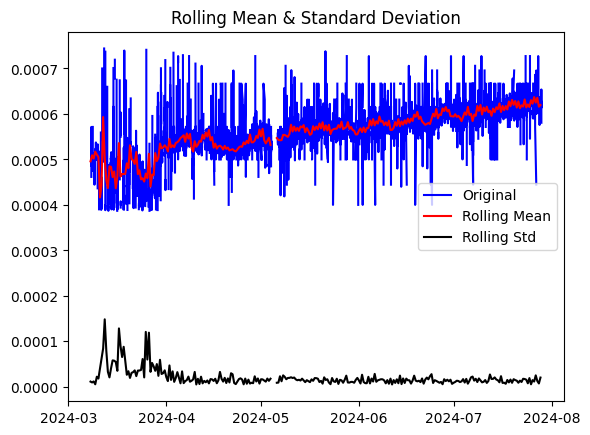

In [7]:
rol_mean = indexed_data['R_normal_3'].resample('12h').mean()
rol_std = indexed_data['R_normal_3'].resample('12h').std()
orig = plt.plot(indexed_data['R_normal_3'], color='blue', label='Original')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

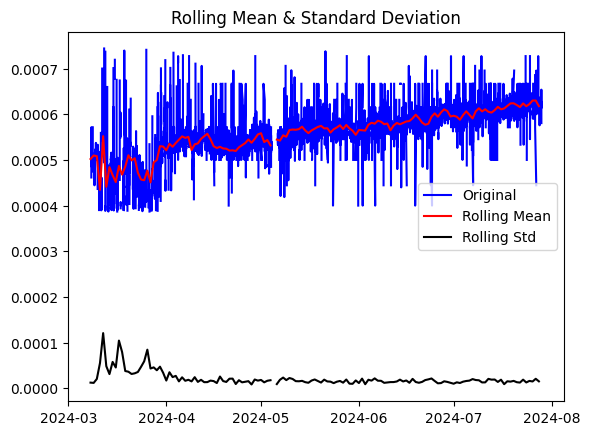

In [8]:
rol_mean = indexed_data['R_normal_3'].resample('D').mean()
rol_std = indexed_data['R_normal_3'].resample('D').std()
orig = plt.plot(indexed_data['R_normal_3'], color='blue', label='Original')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

## Linear Regression

Predicted crossing date: 2029-12-27 05:33:17.080328


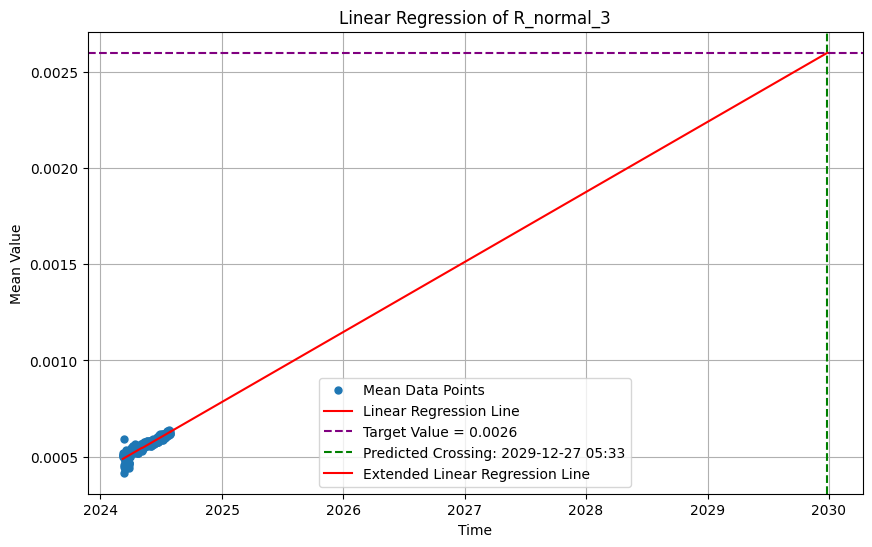

Slope: 4.98248379893722e-07
Intercept: 0.0004881927291382755
R-squared: 0.8270679382594285


In [50]:

target_resistance = 0.026/10
rol_mean = indexed_data['R_normal_3'].resample('12h').mean()
rol_std = indexed_data['R_normal_3'].resample('12h').std()
rol_mean = rol_mean.dropna()

x = np.arange(len(rol_mean))
y = rol_mean.values

slope, intercept, r_value, p_value, std_err = linregress(x, y)

x_target = (target_resistance - intercept) / slope

last_date = rol_mean.index[-1]
predicted_date = last_date + pd.Timedelta(hours=(x_target - len(x)) * 12)

print(f"Predicted crossing date: {predicted_date}")

x_extended = np.arange(len(rol_mean), int(x_target))

y_extended = slope * x_extended + intercept

extended_time = pd.date_range(last_date, periods=len(x_extended) + 1, freq='12h')[1:]

plt.figure(figsize=(10, 6))
plt.plot(rol_mean.index, y, 'o', label='Mean Data Points', markersize=5)
plt.plot(rol_mean.index, slope * x + intercept, 'r-', label='Linear Regression Line')
plt.axhline(target_resistance, color='purple', linestyle='--', label=f'Target Value = {target_resistance}')
plt.axvline(predicted_date, color='green', linestyle='--', label=f'Predicted Crossing: {predicted_date.strftime("%Y-%m-%d %H:%M")}')
plt.plot(extended_time, y_extended, 'r-', label='Extended Linear Regression Line')

plt.title('Linear Regression of R_normal_3')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.legend()
plt.grid()
plt.show()

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")



Predicted crossing date: 2030-09-07 02:54:04.323133536


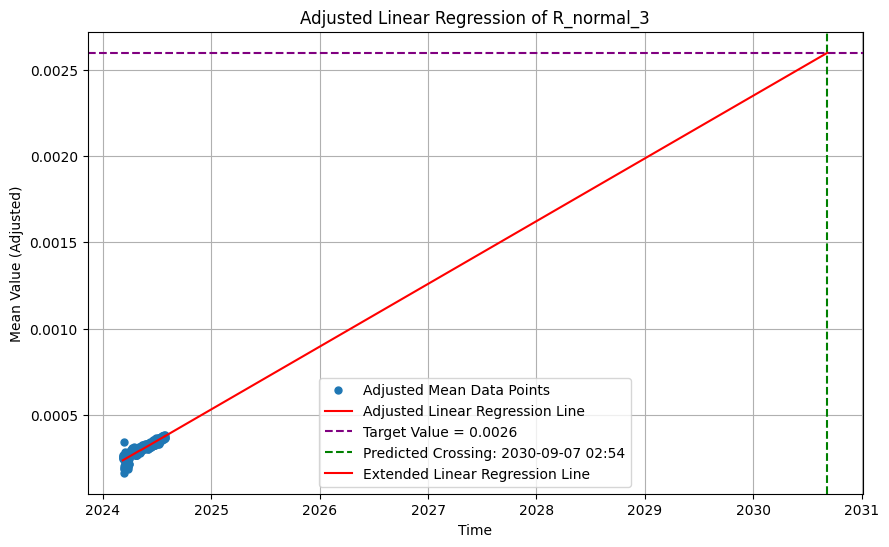

Slope: 4.98248379893722e-07
Intercept: 0.00023519272913827548
R-squared: 0.8270679382594285


In [46]:
# Define the adjustment value (253 µΩ)
adjustment = 0.000253

# Subtract the adjustment from rol_mean values
adjusted_rol_mean = rol_mean - adjustment

# Recompute the regression with the adjusted values
x = np.arange(len(adjusted_rol_mean))
y = adjusted_rol_mean.values

slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the predicted crossing point
x_target = (target_resistance - intercept) / slope

last_date = adjusted_rol_mean.index[-1]
predicted_date = last_date + pd.Timedelta(hours=(x_target - len(x)) * 12)

print(f"Predicted crossing date: {predicted_date}")

# Generate extended regression line
x_extended = np.arange(len(adjusted_rol_mean), int(x_target))
y_extended = slope * x_extended + intercept
extended_time = pd.date_range(last_date, periods=len(x_extended) + 1, freq='12h')[1:]

# Plot the adjusted data and regression
plt.figure(figsize=(10, 6))
plt.plot(adjusted_rol_mean.index, y, 'o', label='Adjusted Mean Data Points', markersize=5)
plt.plot(adjusted_rol_mean.index, slope * x + intercept, 'r-', label='Adjusted Linear Regression Line')
plt.axhline(target_resistance, color='purple', linestyle='--', label=f'Target Value = {target_resistance}')
plt.axvline(predicted_date, color='green', linestyle='--', label=f'Predicted Crossing: {predicted_date.strftime("%Y-%m-%d %H:%M")}')
plt.plot(extended_time, y_extended, 'r-', label='Extended Linear Regression Line')

plt.title('Adjusted Linear Regression of R_normal_3')
plt.xlabel('Time')
plt.ylabel('Mean Value (Adjusted)')
plt.legend()
plt.grid()
plt.show()

# Print regression statistics
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")


## Polynomial Regression

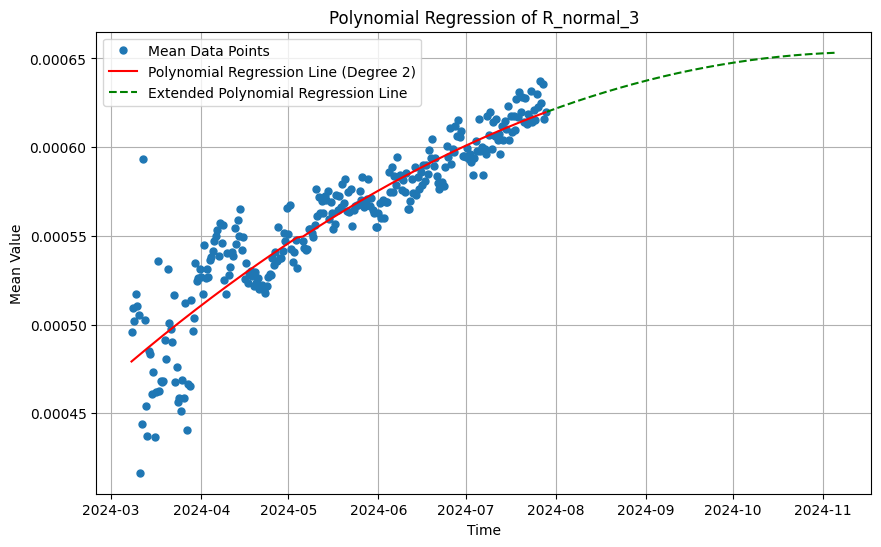

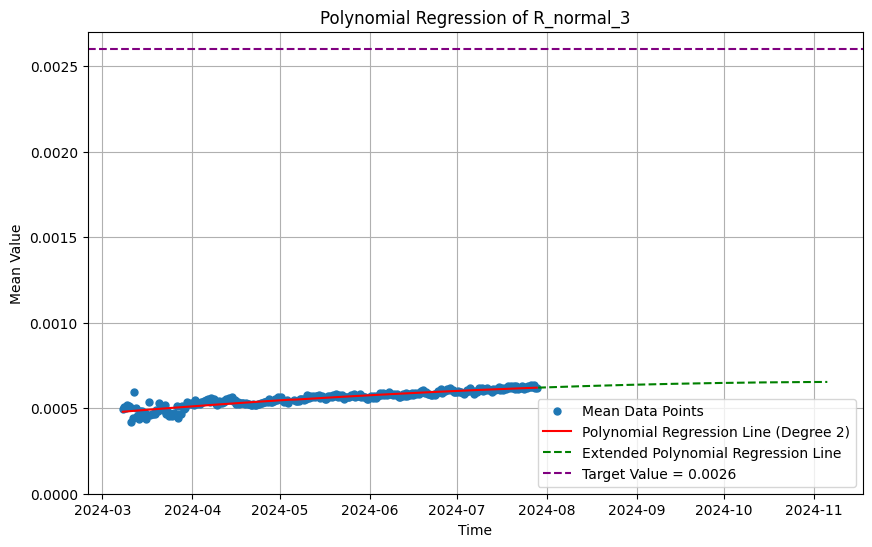

Polynomial Coefficients: [-6.85165458e-10  6.91465039e-07  4.79143749e-04]


In [64]:
rol_mean = indexed_data['R_normal_3'].resample('12h').mean()
rol_std = indexed_data['R_normal_3'].resample('12h').std()
rol_mean = rol_mean.dropna()
boundary_value = 0.0026

x = np.arange(len(rol_mean))
y = rol_mean.values

degree = 2
coeffs = np.polyfit(x, y, degree)
poly = np.poly1d(coeffs)

y_poly = poly(x)

x_extended = np.arange(len(rol_mean), len(rol_mean) + 200)
y_extended = poly(x_extended)

last_date = rol_mean.index[-1]
extended_time = pd.date_range(last_date, periods=len(x_extended) + 1, freq='12h')[1:]

plt.figure(figsize=(10, 6))
plt.plot(rol_mean.index, y, 'o', label='Mean Data Points', markersize=5)
plt.plot(rol_mean.index, y_poly, 'r-', label=f'Polynomial Regression Line (Degree {degree})')
plt.plot(extended_time, y_extended, 'g--', label='Extended Polynomial Regression Line')

plt.title('Polynomial Regression of R_normal_3')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(rol_mean.index, y, 'o', label='Mean Data Points', markersize=5)
plt.plot(rol_mean.index, y_poly, 'r-', label=f'Polynomial Regression Line (Degree {degree})')
plt.plot(extended_time, y_extended, 'g--', label='Extended Polynomial Regression Line')
plt.axhline(target_resistance, color='purple', linestyle='--', label=f'Target Value = {target_resistance}')


plt.ylim(0, 0.0027)

plt.title('Polynomial Regression of R_normal_3')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.legend()
plt.grid()
plt.show()

print(f"Polynomial Coefficients: {coeffs}")


## Preprocessing Data

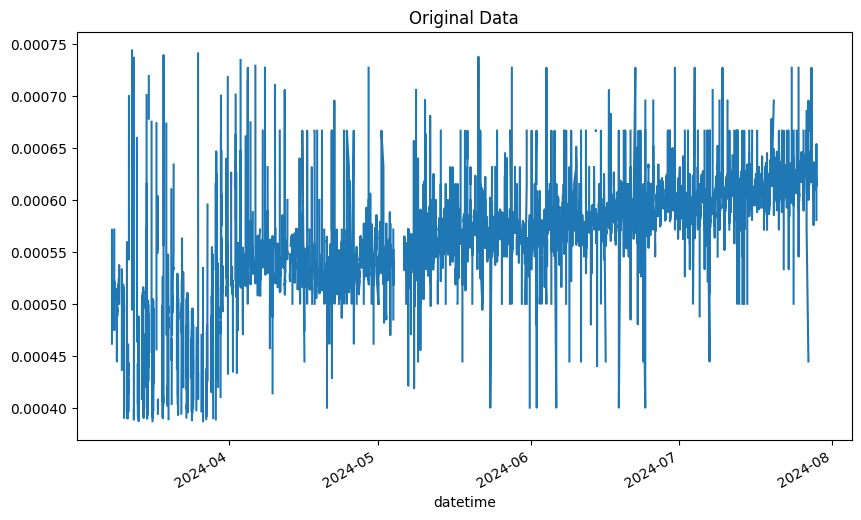

In [11]:
indexed_data['R_normal_3'].plot(title="Original Data", figsize=(10, 6))
plt.show()


(35536,)
(142,)


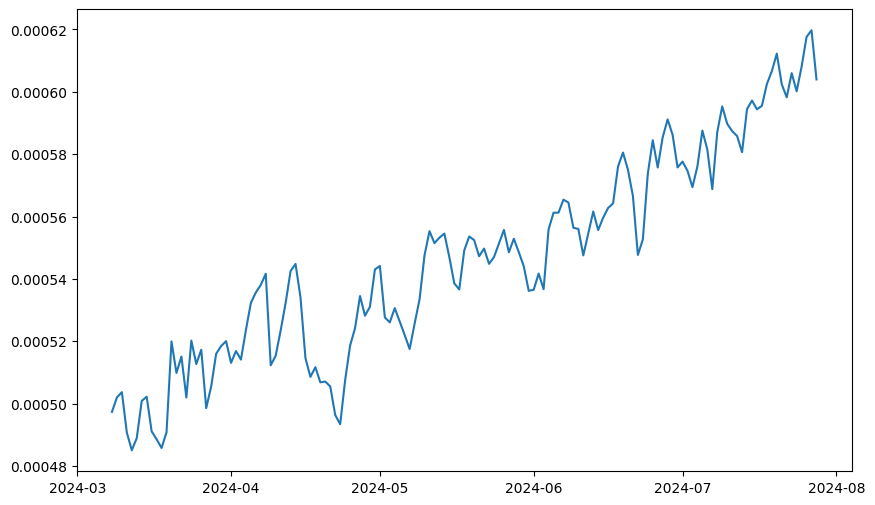

In [12]:
indexed_data['R_normal_mean'] = indexed_data[['R_normal_2', 'R_normal_3', 'R_normal_4', 'R_normal_5', 'R_normal_6', 'R_normal_8', 'R_normal_9', 'R_normal_10']].mean(axis=1)

print(indexed_data['R_normal_mean'].shape)
noise_data = indexed_data['R_normal_mean'].resample('D').mean().dropna()
print(noise_data.shape)
plt.figure(figsize=(10, 6))
plt.plot(noise_data, label='Mean over 1 Sample (Daily))')

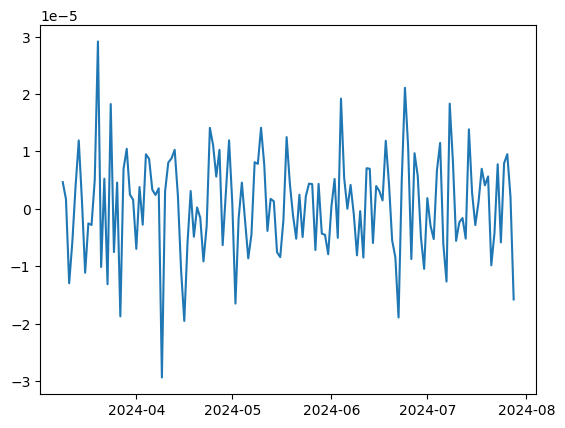

In [13]:
diff_noise_data = noise_data.diff().dropna()

plt.plot(diff_noise_data, label='Difference')


In [14]:
preprocessed_data = diff_noise_data


In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(preprocessed_data, autolag='AIC')  # Use the preprocessed data
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Num of Lags: {result[2]}")
print(f"Num of Observations: {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

if result[1] <= 0.05:
    print("Data is stationary.")
else:
    print("Data is not stationary.")


ADF Statistic: -8.028389104987957
p-value: 1.9886628703343283e-12
Num of Lags: 4
Num of Observations: 136
Critical Values:
	1%: -3.4793722137854926
	5%: -2.8830370378332995
	10%: -2.578233635380623
Data is stationary.


## Auto Regression Model

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

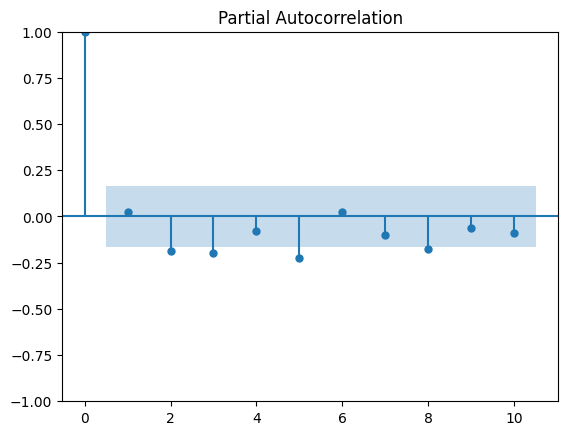

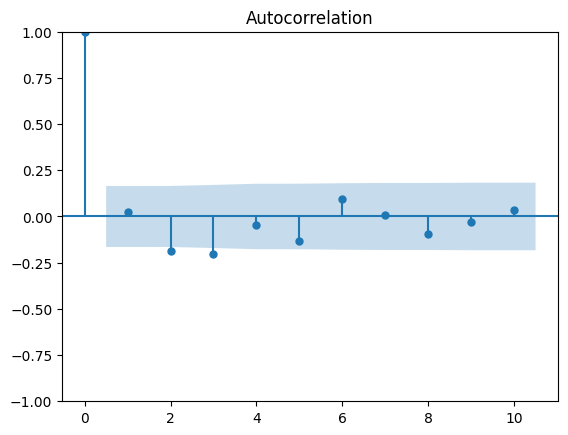

In [17]:
pacf = plot_pacf(preprocessed_data, lags=10)
acf = plot_acf(preprocessed_data, lags=10)

In [18]:
train = preprocessed_data[:len(preprocessed_data)-10]
test = preprocessed_data[len(preprocessed_data)-10:]


In [19]:
model = AutoReg(train, lags=5, trend='t').fit()

print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:          R_normal_mean   No. Observations:                  131
Model:                     AutoReg(5)   Log Likelihood                1295.559
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Mon, 02 Dec 2024   AIC                          -2577.117
Time:                        09:10:31   BIC                          -2557.263
Sample:                             5   HQIC                         -2569.051
                                  131                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
trend             1.786e-08   9.75e-09      1.831      0.067   -1.26e-09     3.7e-08
R_normal_mean.L1    -0.0338      0.087     -0.388      0.698      -0.204       0.137
R_normal_mean.L2    -0.2203 

c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
pred = model.predict(start=len(train), end=len(preprocessed_data)-1, dynamic=False) 
pred.index = preprocessed_data.index[len(train):]

c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


datetime
2024-07-19   -7.389629e-07
2024-07-20    1.864984e-07
2024-07-21    1.425481e-06
2024-07-22    1.737826e-06
2024-07-23    5.092648e-07
2024-07-24    1.856494e-06
2024-07-25    1.728538e-06
2024-07-26    1.449051e-06
2024-07-27    1.201601e-06
2024-07-28    1.496147e-06
dtype: float64
datetime
2024-07-19    0.000004
2024-07-20    0.000006
2024-07-21   -0.000010
2024-07-22   -0.000004
2024-07-23    0.000008
2024-07-24   -0.000006
2024-07-25    0.000008
2024-07-26    0.000010
2024-07-27    0.000002
2024-07-28   -0.000016
Name: R_normal_mean, dtype: float64


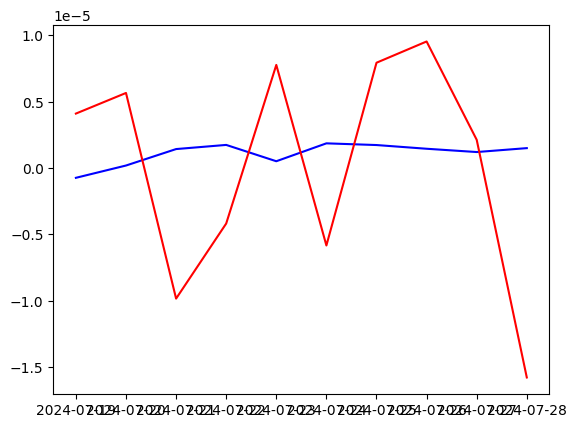

In [21]:
plt.plot(pred, color='blue')
plt.plot(test, color='red')
print(pred)
print(test)

In [22]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, pred))

print(f"RMSE: {rmse}")

RMSE: 8.539461908377194e-06


In [23]:
pred_future = model.predict(start=len(preprocessed_data), end=len(preprocessed_data)+1000, dynamic=False)
pred_future.index = pd.date_range(start=preprocessed_data.index[-1], periods=1002, freq='13h')[1:]

print(pred_future)

2024-07-28 13:00:00    0.000001
2024-07-29 02:00:00    0.000001
2024-07-29 15:00:00    0.000001
2024-07-30 04:00:00    0.000002
2024-07-30 17:00:00    0.000001
                         ...   
2026-01-19 01:00:00    0.000011
2026-01-19 14:00:00    0.000011
2026-01-20 03:00:00    0.000011
2026-01-20 16:00:00    0.000011
2026-01-21 05:00:00    0.000011
Freq: 13h, Length: 1001, dtype: float64


c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\digi1\miniconda3\envs\tf-gpu-2\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


(141,)


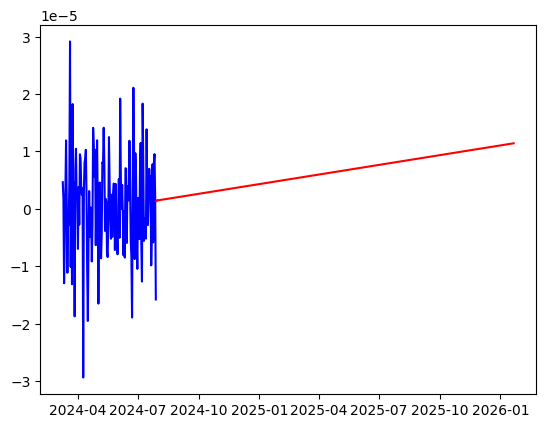

In [24]:
print(preprocessed_data.shape)
plt.plot(preprocessed_data, color='blue')
plt.plot(pred_future, color='red')

## ARIMA Model

In [25]:
from pmdarima import auto_arima
import warnings

warnings.filterwarnings('ignore')

In [26]:
stepwise_fit = auto_arima(preprocessed_data, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2809.382, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2876.178, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2874.249, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2874.154, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2880.683, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2871.869, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.571 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  141
Model:                        SARIMAX   Log Likelihood                1441.341
Date:                Mon, 02 Dec 2024   AIC                          -2880.683
Time:                        09:10:33   BIC                          -2877.734
Sample:                             0   HQIC                         -2879.484
                                - 141                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.734e-11    1.7e-10      0.396      0.692   -2.66e-10       4e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.76   Prob(JB):                         0.10
Heteroskedasticity (H):               0.72   Skew:                            -0.14
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
print(preprocessed_data)
arima_train = preprocessed_data[:len(preprocessed_data)-20]
arima_test = preprocessed_data[len(preprocessed_data)-20:]
print(arima_train.shape, arima_test.shape)

datetime
2024-03-09    0.000005
2024-03-10    0.000002
2024-03-11   -0.000013
2024-03-12   -0.000006
2024-03-13    0.000004
                ...   
2024-07-24   -0.000006
2024-07-25    0.000008
2024-07-26    0.000010
2024-07-27    0.000002
2024-07-28   -0.000016
Name: R_normal_mean, Length: 141, dtype: float64
(121,) (20,)


In [28]:
model = ARIMA(arima_train, order=(1,0,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          R_normal_mean   No. Observations:                  121
Model:                 ARIMA(1, 0, 2)   Log Likelihood                1239.280
Date:                Mon, 02 Dec 2024   AIC                          -2468.560
Time:                        09:10:34   BIC                          -2454.581
Sample:                             0   HQIC                         -2462.883
                                - 121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.707e-07   3.09e-07      1.845      0.065   -3.54e-08    1.18e-06
ar.L1          0.7026    1.3e-13   5.39e+12      0.000       0.703       0.703
ma.L1         -0.7469   4.59e-13  -1.63e+12      0.000      -0.747      -0.747
ma.L2         -0.1806   4.85e-13  -3.72e+11      0.000      -0.181      -0.181
sigma2      9.882e-11   1.86e-10      0.531      0.595   -2.66e-10    4.64e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.58   Prob(JB):                         0.43
Heteroskedasticity (H):               0.64   Skew:                            -0.12
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+28. Standard errors may be unstable.
"""

In [29]:
start = len(arima_train)
end_date = len(arima_train) + len(arima_test) - 1
pred = model.predict(start=start, end=end_date, typ='levels')
print(pred)
pred.index = preprocessed_data.index[start:end_date+1]
print(pred.shape)

121    1.935581e-06
122   -1.645079e-06
123   -9.861165e-07
124   -5.231227e-07
125   -1.978187e-07
126    3.074305e-08
127    1.913328e-07
128    3.041647e-07
129    3.834416e-07
130    4.391422e-07
131    4.782781e-07
132    5.057753e-07
133    5.250951e-07
134    5.386694e-07
135    5.482068e-07
136    5.549079e-07
137    5.596162e-07
138    5.629243e-07
139    5.652485e-07
140    5.668816e-07
Name: predicted_mean, dtype: float64
(20,)


<Axes: xlabel='datetime'>

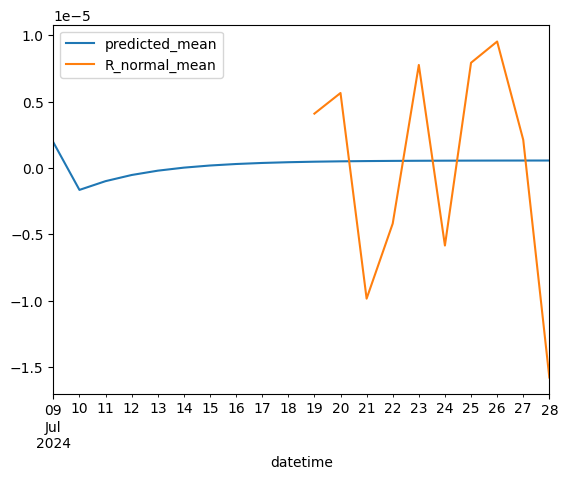

In [30]:
pred.plot(legend=True)
test.plot(legend=True)

In [31]:
rmse = sqrt(mean_squared_error(arima_test, pred))
print(f"RMSE: {rmse}")
print(f"Mean: {arima_test.mean()}")

RMSE: 7.067158244112597e-06
Mean: 8.433721080056523e-07


In [32]:
model2 = ARIMA(preprocessed_data, order=(1,0,2))
model2 = model2.fit()
model2.summary()
preprocessed_data.tail

<bound method NDFrame.tail of datetime
2024-03-09    0.000005
2024-03-10    0.000002
2024-03-11   -0.000013
2024-03-12   -0.000006
2024-03-13    0.000004
                ...   
2024-07-24   -0.000006
2024-07-25    0.000008
2024-07-26    0.000010
2024-07-27    0.000002
2024-07-28   -0.000016
Name: R_normal_mean, Length: 141, dtype: float64>

In [33]:
index_future_dates = pd.date_range(start='2024-07-28', end='2027-07-28', freq='13h')
pred = model2.predict(start=len(preprocessed_data), end=len(preprocessed_data)+1000, typ='levels')
pred.index = index_future_dates[:1001]

<Axes: xlabel='datetime'>

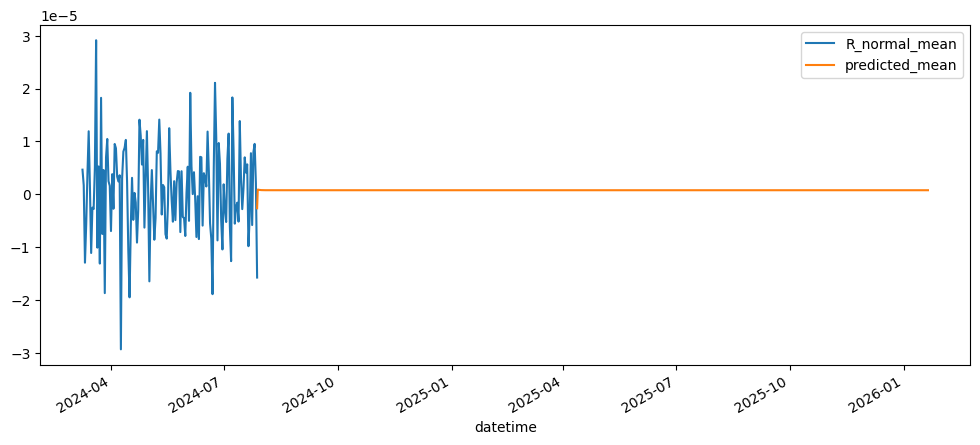

In [34]:
preprocessed_data.plot(figsize=(12, 5), legend=True)
pred.plot(figsize=(12, 5), legend=True)